In [1]:
import matplotlib.pyplot as plt
import numpy as np

from datasets.mnist import MNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn

from models.cem_ibm_model import AEADEN 

import os

In [2]:
dataset = MNIST(batch_size=64)
# dataset = FashionMNIST()

# Training the classifier

In [3]:
cnn = CNN(device='cpu')

train_cnn(cnn, dataset, iterations=50, lr=0.01, device='cpu', save_fn='mnist-cnn-rescaled', load_path="models/saved_models/mnist-cnn.h5")

In [4]:
images, _ = dataset.get_batch()

output = cnn(images)

images = images.numpy()
output = output.detach().numpy()


D:\Programmeren\uva-fact-ai\models\conv_model.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(out)


# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [5]:
# Train or load autoencoder
cae = CAE()

train_ae(cae, dataset, iterations=2, save_fn="mnist-cae", load_path="./models/saved_models/mnist-cae-no-rs.h5")

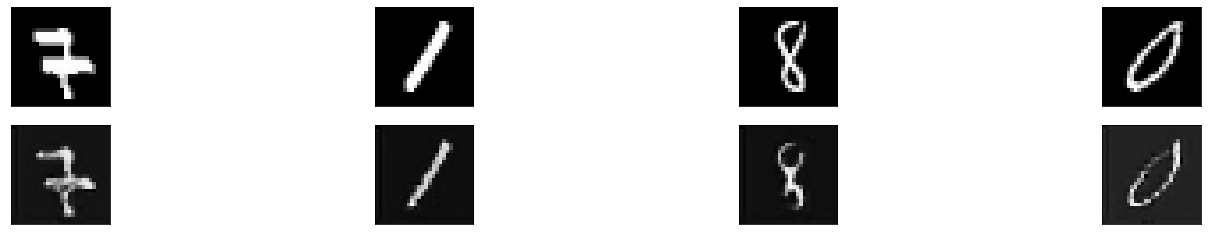

In [6]:
# obtain one batch of test images
images, _ = dataset.get_batch()

#images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = cae(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
# output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Contrastive Explanation Method

In [22]:
kappa = 10
gamma = 100
beta = 1.
lr = 0.1

CEM = AEADEN(model=cnn, AE=cae, max_iterations=200, n_searches=5, mode="PN", init_learning_rate=lr, c_init=0.1, kappa=kappa, gamma=gamma, beta=beta)

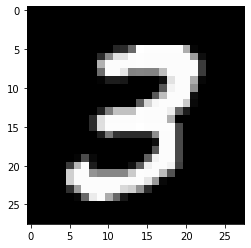

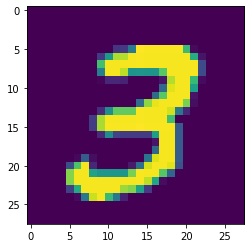

In [23]:
# obtain one sample
image = dataset.get_sample_by_class(class_label=3)

plt.imshow(image.squeeze())


In [24]:
# find pertinent negatives
cnn.float()
CEM.compute_CEM(image)

search:0 iteration:20 lr:0.10 c value:0.10 loss: 0.44 delta sum:46.70 optimum:True y grad:-259.865
search:0 iteration:40 lr:0.09 c value:0.10 loss: 0.00 delta sum:55.07 optimum:True y grad:1889.282
search:0 iteration:60 lr:0.08 c value:0.10 loss: 0.00 delta sum:55.75 optimum:True y grad:5284.322
search:0 iteration:80 lr:0.08 c value:0.10 loss: 0.00 delta sum:63.35 optimum:True y grad:3284.195
search:0 iteration:100 lr:0.07 c value:0.10 loss: 0.00 delta sum:60.37 optimum:True y grad:1287.575
search:0 iteration:120 lr:0.06 c value:0.10 loss: 0.02 delta sum:62.92 optimum:True y grad:2306.656
search:0 iteration:140 lr:0.06 c value:0.10 loss: 0.00 delta sum:60.50 optimum:True y grad:1606.521
search:0 iteration:160 lr:0.05 c value:0.10 loss: 0.00 delta sum:48.91 optimum:True y grad:-1179.765
search:0 iteration:180 lr:0.03 c value:0.10 loss: 0.00 delta sum:49.18 optimum:True y grad:-969.133
search:0 iteration:200 lr:0.01 c value:0.10 loss: 0.00 delta sum:-62.70 optimum:True y grad:-3418.992
h

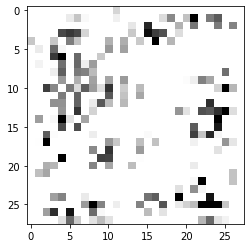

In [25]:
# perturbation
plt.imshow(image.squeeze()- CEM.best_delta.view(28,28), cmap="gray")

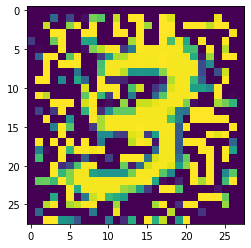

In [26]:
# original image with perturbation
plt.imshow(CEM.delta_tracker[-1].view(28,28))

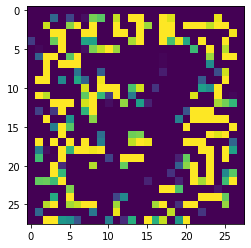

In [27]:
plt.imshow(CEM.delta_tracker[-1].view(28,28)-image.view(28,28))

In [13]:
# classification before
before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
before

3

In [17]:
cnn.double()
# classification after
after = np.argmax(cnn(CEM.delta_tracker[-1].view(1,28,28)).detach()).item()
after

8

In [ ]:
# classification after
cnn.double()
# classification of delta
class_delta = np.argmax(cnn(image.squeeze(-1) - CEM.best_delta.view(1,28,28)).detach()).item()
class_delta

In [ ]:
dirname = "saved_perturbations/kappa-{}-gamma-{}-beta-{}-lr-{}".format(kappa, gamma, beta, lr)
os.makedirs(dirname, exist_ok=True)
fname_orig = dirname + "/{}-cb-{}-ca-{}-orig.png".format(int(time.time()), before, after)
fname_pert = dirname + "/{}-before-{}-after-{}-pert.png".format(int(time.time()), before, after)
fname_combined = dirname + "/{}-before-{}-after-{}-pn.png".format(int(time.time()), before, after)
fname_combined_pp = dirname + "/{}-before-{}-after-{}-pp.png".format(int(time.time()), before, after)
plt.imsave(fname_orig, image.squeeze(), cmap="gray")
plt.imsave(fname_pert, CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
plt.imsave(fname_combined, CEM.best_delta.view(28,28), cmap="gray")
plt.imsave(fname_combined_pp, image.squeeze() - CEM.best_delta.view(28,28))

In [ ]:
print(CEM.best_loss)

In [ ]:
print(CEM.best_pert_loss)

In [ ]:
print(CEM.best_c)